In [1]:
import os
# os.environ["HF_HOME"] = "/workspace/huggingface"
# or
# os.environ["TRANSFORMERS_CACHE"] = "/workspace/hf_models"
import base64
import cv2
import io
import json
import math
import matplotlib.pyplot as plt
import torch
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoModel, AutoImageProcessor
from utils import DINOv2Classifier
from safetensors.torch import load_file as load_safetensors
from IPython.display import display, HTML, Video

import imageio, torch, torch.nn.functional as F
from sam2.sam2_image_predictor  import SAM2ImagePredictor
from sam2.sam2_video_predictor  import SAM2VideoPredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [2]:
# CONFIGURATION
repo_dir = os.getcwd().split('dslab25')[0] + 'dslab25/'
video_path = os.path.join(repo_dir, "assets/vacuum_pump/videos/01_run1_cam_2_1024x1024_15fps_3mbps.mp4")
labels_path = os.path.join(repo_dir, "assets/vacuum_pump/videos/output.txt")
coco_path = os.path.join(repo_dir, "training/vacuum_pump/coco_annotations.json")

# Path to your trained YOLOv12 weights (adjust as needed)
temp_images_dir = os.path.join(repo_dir, "temp_images")
anno_dir = os.path.join(repo_dir, "assets/vacuum_pump/eval/anno")
base_dir = os.path.join(repo_dir, "training/vacuum_pump")

coco_path = os.path.join(base_dir, "coco_annotations.json")
YOL_THRESHOLD = 0.38

os.makedirs(temp_images_dir, exist_ok=True)

In [3]:
pretrained_model = "facebook/dinov2-with-registers-base"
yolo_model_path = os.path.join(repo_dir, "obj_detection/dino/yolo_runs/yolov12_boundingbox2", "weights", "best.pt")
model_dir = os.path.join(repo_dir, "obj_detection/dino/dinov2_finetune/base/final_model/")

In [4]:
def load_labels(labels_path):
	"""Load ground truth labels from file."""
	frame_to_class = {}
	with open(labels_path, 'r') as f:
		for line in f:
			parts = line.strip().split()
			if len(parts) == 3:
				state_class, start_frame, end_frame = int(parts[0]), int(parts[1]), int(parts[2])
				for frame_idx in range(start_frame, end_frame + 1):
					frame_to_class[frame_idx] = state_class
	return frame_to_class

# Load ground truth labels.
print(f"Loading labels from: {labels_path}")
frame_to_class = load_labels(labels_path)

# Load COCO annotations to map category IDs to names.
print(f"Loading COCO annotations from: {coco_path}")
try:
	with open(coco_path, 'r') as f:
		coco_data = json.load(f)
	category_id_to_name = {cat['id']: cat.get('name', f'category_{cat["id"]}')
								for cat in coco_data.get('categories', [])}
except (FileNotFoundError, json.JSONDecodeError) as e:
	print(f"Error loading COCO annotations: {e}")
	category_id_to_name = {}


Loading labels from: /workspace/dslab25/assets/vacuum_pump/videos/output.txt
Loading COCO annotations from: /workspace/dslab25/training/vacuum_pump/coco_annotations.json


# Yolo

In [6]:
# print("Loading YOLO model...")
# yolo_model = YOLO(yolo_model_path)


# DinoV2 (init)

In [8]:
from glob import glob
pretrained_model = "facebook/dinov2-with-registers-base"
image_files = sorted(glob(os.path.join(temp_images_dir, "*.jpg")))
correct_predictions = 0
total_predictions = 0

# Load image processor and model
print("Loading image processor...")
processor = AutoImageProcessor.from_pretrained(pretrained_model)

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get number of classes from frame_to_class
num_labels = max(frame_to_class.values()) + 1 if frame_to_class else 8
print(f"Number of classes: {num_labels}")

# Load model
print("Loading model...")
model = DINOv2Classifier(num_labels=num_labels, pretrained_model=pretrained_model)

# Load model weights
safetensors_path = os.path.join(model_dir, "model.safetensors")
bin_path = os.path.join(model_dir, "pytorch_model.bin")

model_weights_path = None
if os.path.exists(safetensors_path):
	model_weights_path = safetensors_path
elif os.path.exists(bin_path):
	model_weights_path = bin_path
	
if model_weights_path:
	print(f"Loading model weights from: {model_weights_path}")
	try:
		if model_weights_path.endswith(".safetensors"):
			state_dict = load_safetensors(model_weights_path, device=str(device))
		else:
			state_dict = torch.load(model_weights_path, map_location=str(device), weights_only=True)
			
		# Handle potential DDP prefix
		if next(iter(state_dict)).startswith('module.'):
			state_dict = {k.partition('module.')[2]: v for k,v in state_dict.items()}
				
		model.load_state_dict(state_dict)
	except Exception as e:
		raise e
else:
	raise Exception(f"Error: Model weights not found in {model_dir}")


model.to(device)
model.eval()


Loading image processor...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
Number of classes: 8
Loading model...


Some weights of Dinov2WithRegistersForImageClassification were not initialized from the model checkpoint at facebook/dinov2-with-registers-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model weights from: /workspace/dslab25/obj_detection/dino/dinov2_finetune/base/final_model/model.safetensors


DINOv2Classifier(
  (model): Dinov2WithRegistersForImageClassification(
    (dinov2_with_registers): Dinov2WithRegistersModel(
      (embeddings): Dinov2WithRegistersEmbeddings(
        (patch_embeddings): Dinov2WithRegistersPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): Dinov2WithRegistersEncoder(
        (layer): ModuleList(
          (0-11): 12 x Dinov2WithRegistersLayer(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attention): Dinov2WithRegistersAttention(
              (attention): Dinov2WithRegistersSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): Dinov2WithRegistersSelfOutp

# Frame rejection (CV)

In [9]:
from skimage.draw import polygon
from sklearn.neighbors import NearestNeighbors
import pickle
import torch.nn as nn
import torch.nn.functional as F

mask_ref_path = os.path.join(repo_dir, "obj_detection/dino/", "ref_mask.pkl")
iou_threshold = 0.6 
expected_scale = 0.65 # obtained from reference-5-render vs. clean frame 70
scale_tolerance = 0.1

def crop_mask(mask: np.ndarray) -> np.ndarray:
	if not np.any(mask):
		return np.zeros((0, 0), dtype=bool)  # or return the original mask if preferred

	rows = np.any(mask, axis=1)
	cols = np.any(mask, axis=0)

	rmin, rmax = np.where(rows)[0][[0, -1]]
	cmin, cmax = np.where(cols)[0][[0, -1]]

	return mask[rmin:rmax+1, cmin:cmax+1]


def euclidean_distance(point1, point2):
	a = np.array(point1)
	b = np.array(point2)
	return np.linalg.norm(a - b, ord=2)


def point_based_matching(point_pairs):
	x_mean = y_mean = xp_mean = yp_mean = 0
	n = len(point_pairs)

	if n == 0:
		return None, None, None, None

	for (x, y), (xp, yp) in point_pairs:
		x_mean += x
		y_mean += y
		xp_mean += xp
		yp_mean += yp

	x_mean /= n
	y_mean /= n
	xp_mean /= n
	yp_mean /= n

	s_x_xp = s_y_yp = s_x_yp = s_y_xp = 0
	sigma_xx = sigma_yy = 0
	for (x, y), (xp, yp) in point_pairs:
		dx = x - x_mean
		dy = y - y_mean
		dxp = xp - xp_mean
		dyp = yp - yp_mean

		s_x_xp += dx * dxp
		s_y_yp += dy * dyp
		s_x_yp += dx * dyp
		s_y_xp += dy * dxp

		sigma_xx += dx * dx
		sigma_yy += dy * dy

	rot_angle = math.atan2(s_x_yp - s_y_xp, s_x_xp + s_y_yp)
	c, s = math.cos(rot_angle), math.sin(rot_angle)

	numerator = s_x_xp + s_y_yp
	denominator = sigma_xx + sigma_yy
	scale = numerator / denominator if denominator != 0 else 1.0

	tx = xp_mean - scale * (x_mean * c - y_mean * s)
	ty = yp_mean - scale * (x_mean * s + y_mean * c)

	return rot_angle, tx, ty, scale


def icp(reference_points, points, max_iterations=200, distance_threshold=20.0,
		convergence_translation_threshold=1e-3, convergence_rotation_threshold=1e-4,
		convergence_scale_threshold=1e-4, point_pairs_threshold=5, verbose=False):
	nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(reference_points)
	src = points.copy()

	# Cumulative transformation: initialize
	total_rotation = 0.0
	total_scale = 1.0
	total_translation = np.zeros(2)

	for iter_num in range(max_iterations):
		if verbose:
			print(f'--- ICP Iteration {iter_num} ---')

		closest_point_pairs = []

		distances, indices = nbrs.kneighbors(src)
		for i in range(len(distances)):
			if distances[i][0] < distance_threshold:
				closest_point_pairs.append((src[i], reference_points[indices[i][0]]))

		if verbose:
			print(f'Point pairs found: {len(closest_point_pairs)}')
		if len(closest_point_pairs) < point_pairs_threshold:
			if verbose:
				print("Too few point pairs — stopping.")
			break

		angle, tx, ty, scale = point_based_matching(closest_point_pairs)
		if angle is None:
			break

		# Compose this iteration's transform
		c, s = math.cos(angle), math.sin(angle)
		R = np.array([[c, -s], [s, c]])
		src = scale * (src @ R.T)
		src[:, 0] += tx
		src[:, 1] += ty

		# Update cumulative transform
		total_rotation += angle
		total_scale *= scale
		total_translation = scale * (total_translation @ R.T) + [tx, ty]

		if abs(angle) < convergence_rotation_threshold and \
			abs(tx) < convergence_translation_threshold and \
			abs(ty) < convergence_translation_threshold and \
			abs(scale-1) < convergence_scale_threshold:
			if verbose:
				print(f"Converged after {iter_num+1} iterations.")
			break

	# Return final aligned points and full transformation
	transform = {
		"rotation": total_rotation,				 # angle in radians
		"scale": total_scale,					   # scalar
		"translation": total_translation.tolist(),  # [tx, ty]
	}

	return transform, src


def get_largest_contour(mask):
	mask_u8 = (mask.astype(np.uint8)) * 255
	contours, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
	if not contours:
		return None
	return max(contours, key=cv2.contourArea)[:, 0, :].astype(np.float32)


def contour_to_mask(shape, contour):
	rr, cc = polygon(contour[:, 1], contour[:, 0], shape)
	mask = np.zeros(shape, dtype=bool)
	mask[rr, cc] = True
	return mask


def get_aligned_iou(mask, mask_ref, max_points=200):
	"""
	mask: mask of the current object to be matched to the mask of reference object (mask_ref)
	"""
	mask1 = crop_mask(mask_ref)
	mask2 = crop_mask(mask)

	contour1 = get_largest_contour(mask1)
	contour2 = get_largest_contour(mask2)
	if contour1 is None or contour2 is None:
		return 0.0

	N = min(len(contour1), len(contour2), max_points)
	idx1 = np.linspace(0, len(contour1) - 1, N).astype(int)
	idx2 = np.linspace(0, len(contour2) - 1, N).astype(int)
	points1 = contour1[idx1]
	points2 = contour2[idx2]

	trans, aligned_points2 = icp(
		reference_points=points1,
		points=points2,
		max_iterations=200,
		point_pairs_threshold=N//10,
		distance_threshold=150,
		convergence_translation_threshold=1e-3,
		convergence_rotation_threshold=1e-4,
		convergence_scale_threshold=1e-3,
		verbose=False
	)

	aligned_mask = contour_to_mask(mask1.shape, aligned_points2)

	intersection = np.logical_and(mask1, aligned_mask).sum()
	union = np.logical_or(mask1, aligned_mask).sum()
	iou = intersection / union if union > 0 else 0.0
	return iou, trans


with open(mask_ref_path, 'rb') as f:
	mask_ref = crop_mask(pickle.load(f))

# Yolo (Seed Frame)

In [ ]:
boxed_out = "sam2_boxed.mp4"
device = "cuda" if torch.cuda.is_available() else "cpu"
skip_frames = 0

yolo_model = YOLO(yolo_model_path)
img_pred = SAM2ImagePredictor.from_pretrained("facebook/sam2.1-hiera-tiny")
mask_gen = SAM2AutomaticMaskGenerator(
	img_pred.model,
	points_per_side=32,
	pred_iou_thresh=0.7,		  # only keep masks with IoU-pred confidence ≥ 0.7
	stability_score_thresh=0.9,   # only keep very stable masks
	box_nms_thresh=0.3,		   # merge overlapping boxes more aggressively
	min_mask_region_area=1000	 # drop very small regions
)


cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
	raise IOError(f"cannot open {video_path}")
frames = []
ret, frm = cap.read()
fps = cap.get(cv2.CAP_PROP_FPS) or 30
H, W = frm.shape[:2]
while True:
	if not ret: break
	frm = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
	ret, frm = cap.read()
	yolo_results = yolo_model(frm)
	if len(yolo_results) == 0 or len(yolo_results[0].boxes) == 0:
		continue

	boxes = yolo_results[0].boxes.data
	curr_max = YOL_THRESHOLD
	box_max = None
	for box in boxes:
		if box[4].item() > curr_max:
			curr_max = box[4].item()
			box_max = box
	
	best_m = None
	if box_max:
		masks = mask_gen.generate(frm)
		for idx, m in enumerate(masks):
			masked = frm.copy()
			masked[~m["segmentation"]] = 0 # zero out background
			yolo_results = yolo_model(masked)        # a list of `ultralytics.yolo.engine.results.Results`
			boxes = yolo_results[0].boxes.data
			if any([box[4].item() > YOL_THRESHOLD for box in boxes]):
				best_m = m
				break
	if best_m:
		break
cap.release()


seed_frame = frames[skip_frames]
if best_m is None:
	raise RuntimeError("No mask matched the reference images!")

# SAM 2

In [10]:
mask0 = torch.from_numpy(best_m["segmentation"]).to(device).bool()
# ── 4. INITIALISE MODELS ────────────────────────────────────────────────────
backbone_name = "facebook/dinov2-with-registers-small"
dinov2_backbone = AutoModel.from_pretrained(backbone_name).to(device).eval()
dinov2_proc = AutoImageProcessor.from_pretrained(backbone_name)

vid_pred = SAM2VideoPredictor.from_pretrained("facebook/sam2.1-hiera-tiny")

# ── 6. AUTO MASKS ON SEED FRAME ─────────────────────────────────────────────

# ── 8. TRACK & DRAW BOX (SKIPPING FIRST 70 FRAMES) ──────────────────────────
# --- use the MP4 path rather than a tensor ---
state = vid_pred.init_state(video_path=video_path)

vid_pred.add_new_mask(state, frame_idx=skip_frames, mask=mask0, obj_id=0)
writer = imageio.get_writer(
	boxed_out,
	format="FFMPEG",	# force the FFmpeg plugin
	codec="libx264",	# MP4/H.264 codec
	fps=fps,
	ffmpeg_params=["-pix_fmt", "yuv420p"]  # ensures broad compatibility
)
num_accepted = 0
num_correct = 0
with torch.inference_mode(), torch.autocast(device_type=device, dtype=torch.bfloat16):
	for f_idx, _, logits in vid_pred.propagate_in_video(state):
		if f_idx < 90:
			continue

		mask2d = logits.sigmoid()[0].squeeze(0) > 0.5
		frame   = frames[f_idx].copy()

		if mask2d.any():
			ys, xs = np.where(mask2d.cpu().numpy())
			x0b, y0b, x1b, y1b = xs.min(), ys.min(), xs.max(), ys.max()

			# ----- classification --------------------------------------------


			mask_cropped = crop_mask(mask2d.cpu().numpy())
			iou, trans = get_aligned_iou(mask_cropped, mask_ref)
			scale = trans['scale']
			iou_reject = bool(iou is None or iou < iou_threshold)
			scale_reject = bool(scale is None or abs(float(scale) - expected_scale) > scale_tolerance)
			rejected = iou_reject #or scale_reject

			color = (0, 255, 0) if not rejected else (255, 0, 0)
			cv2.rectangle(frame, (x0b, y0b), (x1b, y1b), color, 2)

			if rejected:
				label_txt = f"rejected% true: {frame_to_class[f_idx]}"
			else:
				num_accepted += 1

				crop_rgb = frames[f_idx][y0b:y1b, x0b:x1b]
				batch = processor(images=[crop_rgb], return_tensors="pt").to(device)
				cls_logits = model(**batch).logits.squeeze(0)
				probs = torch.softmax(cls_logits, dim=-1)
				cls_id = probs.argmax().item()
				conf = probs[cls_id].item()

				true_cls = frame_to_class[f_idx]
				# ---- custom equivalence logic ----
				def equivalent(c1, c2):
					if {c1, c2} <= {4, 5}: return True
					if {c1, c2} <= {6, 7}: return True
					return c1 == c2

				if equivalent(cls_id, true_cls):
					num_correct += 1

				label_txt = f"class {cls_id}  {conf*100:.1f}% true: {true_cls}"


			cv2.putText(frame, label_txt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
						0.9, (0, 0, 0), 3, cv2.LINE_AA)
			cv2.putText(frame, label_txt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
							0.9, (0, 255, 0), 2, cv2.LINE_AA)

			# if f_idx % 10 == 0:  # To avoid showing every frame
			# 	plt.figure(figsize=(12, 6))

			# 	# Show original frame
			# 	plt.subplot(1, 3, 1)
			# 	plt.imshow(frame[..., ::-1])  # BGR to RGB
			# 	plt.title("Frame")
			# 	plt.axis('off')

			# 	# Show reference mask
			# 	plt.subplot(1, 3, 2)
			# 	plt.imshow(mask_ref, cmap='gray')
			# 	plt.title("Mask Ref")
			# 	plt.axis('off')

			# 	# Show cropped mask
			# 	plt.subplot(1, 3, 3)
			# 	plt.imshow(mask_cropped, cmap='gray')
			# 	plt.title("Mask Cropped")
			# 	plt.axis('off')

			# 	# Add global info
			# 	info_lines = [f"IoU: {iou:.3f}" if iou is not None else "IoU: None"]
			# 	if scale is not None:
			# 		scale_diff = abs(float(scale) - expected_scale)
			# 		info_lines.append(f"Scale diff: {scale_diff:.3f}")
			# 	else:
			# 		info_lines.append("Scale: None")

			# 	plt.suptitle("\n".join(info_lines), fontsize=14, y=1.05)
			# 	plt.tight_layout()
			# 	plt.show()
		writer.append_data(frame)
writer.close()

# 9. DISPLAY RESULT ----------------------------------------------------------
Video(boxed_out, embed=True, width=min(W, 640))

print(f"\nAccepted frames: {num_accepted}")
print(f"Correct predictions: {num_correct}")

if num_accepted > 0:
	accuracy = num_correct / num_accepted
	print(f"Accuracy: {accuracy:.2%}")
else:
	print("No accepted frames, accuracy undefined.")

propagate in video: 100%|██████████| 1786/1786 [01:22<00:00, 21.71it/s]



Accepted frames: 488
Correct predictions: 451
Accuracy: 92.42%


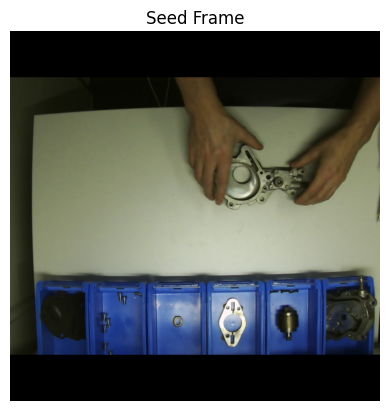

In [11]:
import matplotlib.pyplot as plt

plt.imshow(seed_frame)
plt.title("Seed Frame")
plt.axis("off")
plt.show()

# DinoV2 (inference)

In [12]:
# correct_predictions = 0
# total_predictions   = 0
# print(frame_to_class)
# for f_idx, _, logits_map in vid_pred.propagate_in_video(state):
# 	if f_idx < skip_frames:
# 		continue

# 	# ── binary mask ──────────────────────────────────────────────────────────
# 	mask_2d = logits_map.sigmoid()[0].squeeze(0) > 0.5
# 	if not mask_2d.any():
# 		continue

# 	# ── crop the bounding box ───────────────────────────────────────────────
# 	ys, xs = np.where(mask_2d.cpu().numpy())
# 	x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
# 	crop_rgb = frames[f_idx][y0:y1, x0:x1]		  # H×W×3, uint8
# 	# display(crop_rgb)

# 	# ── DINO-style inference on the crop ────────────────────────────────────
# 	batch		 = processor(images=crop_rgb, return_tensors="pt").to(device)
# 	with torch.no_grad():
# 		logits = model(pixel_values=batch["pixel_values"]).logits.squeeze(0)  # (C,)

# 	probs		   = torch.softmax(logits, dim=-1).cpu()   # tensor -> CPU
# 	predicted_label = probs.argmax().item()
# 	true_label = frame_to_class[f_idx]				  # <- however you load it

# 	# ── print per-frame info ────────────────────────────────────────────────
# 	# print(f"\nFrame {f_idx} — class probabilities:")
# 	# print(probs.tolist())		  # one line per frame
# 	print(f"pred: {predicted_label}  true: {true_label}"
# 		  f"  {'✅' if predicted_label == true_label else '❌'}")

# 	# ── bookkeeping ─────────────────────────────────────────────────────────
# 	correct_predictions += 1 if predicted_label == true_label else 0
# 	total_predictions   += 1

# # ── summary ─────────────────────────────────────────────────────────────────
# accuracy = correct_predictions / total_predictions if total_predictions else 0
# print("\nEvaluation Summary")
# print(f"  evaluated: {total_predictions}")
# print(f"  correct:   {correct_predictions}")
# print(f"  accuracy:  {accuracy:.2%}")



In [13]:
# correct_predictions = 0
# total_predictions = 0

# for image_path in image_files:
# 	# Infer annotation file path
# 	filename = os.path.splitext(os.path.basename(image_path))[0]
# 	anno_path = os.path.join(anno_dir, f"{filename}.txt")
# 	print(anno_path)
# 	if not os.path.exists(anno_path):
# 		print(f"Annotation not found for {filename}, skipping.")
# 		continue

# 	# Read true class label
# 	with open(anno_path, "r") as f:
# 		try:
# 			true_label = int(f.readline().strip())
# 		except ValueError:
# 			print(f"Invalid label in {anno_path}, skipping.")
# 			continue

# 	# Load image
# 	image = Image.open(image_path).convert("RGB")
# 	display(image)

# 	# Process image
# 	inputs = processor(images=image, return_tensors="pt")
# 	pixel_values = inputs["pixel_values"].to(device)
# 	with torch.no_grad():
# 		outputs = model(pixel_values=pixel_values)
	
# 	logits = outputs["logits"]
# 	probs = torch.softmax(logits, dim=-1)
# 	print("Probabilities:", probs)
# 	predicted_label = logits.argmax(-1).item()

# 	# Inside your loop:
# 	is_correct = labels_match(predicted_label, true_label)
# 	if is_correct:
# 		correct_predictions += 1
# 	total_predictions += 1

# 	print(f"{filename}:")
# 	print(f"	True:	{true_label}")
# 	print(f"	Predicted: {predicted_label}")
# 	print(f"	Correct:	 {'✅ Yes' if is_correct else '❌ No'}")
# 	print("-" * 30)

# accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
# print("\nEvaluation Summary:")
# print(f"	Total evaluated: {total_predictions}")
# print(f"	Correct:		 {correct_predictions}")
# print(f"	Accuracy:		{accuracy:.2f}")

# Qwen VL

In [14]:
# from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
# from qwen_vl_utils import process_vision_info


# states = {
# 	'state_0': 'Base block metal piece',
# 	'state_1': 'Cylinder metal piece which gets stick on the base block stage_0',
# 	'state_2': 'A Big metal piece which gets stick on the cylinder piece of stage_1',
# 	'state_3': 'A smaller thin metal piece which gets put onto the center of the big metal piece of stage_2',
# 	'state_4': 'A tiny metal ring which gets placed onto the center of the thing metal piece of stage_3',
# 	'state_5': '3 screws now get screwed onto the piece',
# 	'state_6': 'A darker metal plate now gets placed on top of the piece',
# 	'state_7': '5 screws now get screwed onto the piece',
# }

# # We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# qwen_vl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
# 	"Qwen/Qwen2.5-VL-7B-Instruct",
# 	torch_dtype=torch.bfloat16,
# 	# attn_implementation="flash_attention_2",
# 	device_map="auto",
# )

# # default processer
# qwen_vl_processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# # Messages containing a local video path and a text query

In [15]:
# # Messages containing a local video path and a text query

# def display_images_horizontal(image_paths, size=(100, 100)):
# 	html = '<div style="display: flex; flex-direction: row;">'
# 	for path in image_paths:
# 		img = Image.open(path).resize(size)
# 		buffer = io.BytesIO()
# 		img.save(buffer, format='PNG')
# 		img_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
# 		html += f'<img src="data:image/png;base64,{img_str}" style="margin:2px;" />'
# 	html += '</div>'
# 	display(HTML(html))
	
# def qwen_vl(image_paths: list[str], current_dino_state: str, previous_qwen_state: str, previous_information: str):
# 	"""
# 	[
# 		"file:///path/to/frame1.jpg",
# 		"file:///path/to/frame2.jpg",
# 		"file:///path/to/frame3.jpg",
# 		"file:///path/to/frame4.jpg",
# 	],
# 	"""
# 	messages = [
# 		{
# 			"role": "user",
# 			"content": [
# 			{
# 				"type": "video",
# 				"video": image_paths
# 			},
# 			{
# 				"type": "text",
# 				"text": f'''
# 					You are given a short video clip of a person assembling an object. The clip is part of a longer clip of the person assembling the object.
# 					Your task is it to tell me what you see in the video and based on that and the previous action, some more information below make a prediction on which state the piece is at the end of the clip.
# 					Note that the clip may end while the person is still in the middle of an action.
# 					If the state is in between two states, return the state it was in before, so if the person is moving the cylinder piece to the base block, return state_0, only when the cylinder piece is on the base block, return state_1.
# 					Here are the possible states:
# 						'state_0': 'First part of the object: Base block metal piece',
# 						'state_1': 'Second part of the object: Cylinder metal piece which gets stick on the base block stage_0',
# 						'state_2': 'Third part of the object: A Big metal piece which gets stick on the cylinder piece of stage_1',
# 						'state_3': 'Fourth part of the object: A smaller thin metal piece which gets put onto the center of the big metal piece of stage_2',
# 						'state_4': 'Fifth part of the object: A tiny metal ring which gets placed onto the center of the thing metal piece of stage_3',
# 						'state_5': 'Sixth part of the object: 3 screws now get screwed onto the piece',
# 						'state_6': 'Seventh part of the object: A darker metal plate now gets placed on top of the piece',
# 						'state_7': 'Eighth part of the object: 5 screws now get screwed onto the piece'
# 					Additionally I will give you the state in which the classifier thinks the piece is at.
# 					Here is the information (it might be none id it didnt predict anything):
# 						{current_dino_state}
# 					Additionally I will give you the state in which the classifier thinks the piece was at at the beginning of the clip.
# 					Here is the information ((it might be none id it didnt predict anything)):
# 						{previous_qwen_state}
# 					Additionally, I will give you some information about what the person did 5 seconds before the clip starts.
# 					Here is the information:
# 						{previous_information}

# 					Please return the output in the following format:
# 					{{
# 						"state": "state_name",
# 						"action_description": "action_description"
# 					}}
# 				'''},
# 				],
# 			}
# 		]

# 	text = qwen_vl_processor.apply_chat_template(
# 		messages, tokenize=False, add_generation_prompt=True
# 	)
# 	image_inputs, video_inputs = process_vision_info(messages)
# 	inputs = qwen_vl_processor(
# 		text=[text],
# 		images=image_inputs,
# 		videos=video_inputs,
# 		fps=fps,
# 		padding=True,
# 		return_tensors="pt",
		
# 	)
# 	inputs = inputs.to("cuda")

# 	# Inference
# 	generated_ids = qwen_vl_model.generate(**inputs, max_new_tokens=128)
# 	generated_ids_trimmed = [
# 		out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# 	]
# 	output_text = qwen_vl_processor.batch_decode(
# 		generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# 	)
# 	print(output_text)
# 	return output_text

# previous_qwen_state = "None because its the first clip"
# previous_information = "None because its the first clip"
# current_dino_state = "None because its the first clip"

# correct_predictions = 0
# total_predictions = 0

# for idx in range(0, len(frames_to_process), 9):
# 	image_paths = []
# 	for frame_idx, frame in frames_to_process[idx:idx+9]:
# 		frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# 		image = Image.fromarray(frame_rgb)
# 		image_path = os.path.join(temp_images_dir, f"frame_{frame_idx}_original.jpg")
# 		image.save(image_path)
# 		image_paths.append(f'file://{image_path}')
# 	print("image_paths:", image_paths)
# 	# yolo_results = yolo_model(frame)
# 	# skip_to_qwen = False
# 	# if len(yolo_results) == 0 or len(yolo_results[0].boxes) == 0:
# 	# 	print(f"Frame {frame_idx}: No detection found. Skipping frame.")
# 	# 	skip_to_qwen = True
# 	true_label = frame_to_class[frame_idx]
# 	true_label_name = category_id_to_name.get(true_label, f"Class_{true_label}")
# 	if not True:
# 		boxes = yolo_results[0].boxes.data	# Each row: [x1, y1, x2, y2, conf, cls]

# 		# Find the box with the highest confidence
# 		highest_conf_idx = -1
# 		highest_conf = 0

# 		for idx, box in enumerate(boxes):
# 			confidence = box[4].item()
# 			if confidence < YOL_THRESHOLD:
# 				continue
			
# 			if confidence > highest_conf:
# 				highest_conf = confidence
# 				highest_conf_idx = idx
		
# 		if highest_conf_idx >= 0:
# 			box = boxes[highest_conf_idx]
# 			confidence = box[4].item()
# 			predicted_label = int(box[5].item())
# 			current_dino_state = category_id_to_name.get(predicted_label, f"Class_{predicted_label}")
			
# 			x1, y1, x2, y2 = map(int, box[:4].tolist())
# 			x1 = max(0, x1)
# 			y1 = max(0, y1)
# 			x2 = min(image.width, x2)
# 			y2 = min(image.height, y2)
			
# 			cropped_image = image.crop((x1, y1, x2, y2))
# 			cropped_path = os.path.join(temp_images_dir, f"frame_{frame_idx}.jpg")
# 			cropped_image.save(cropped_path)
			
# 			print(f"Saved cropped image: {cropped_path}")
# 		else:
# 			current_dino_state = "None, Dino didnt make a prediction"
			
# 	display_images_horizontal([img.replace('file://', '') for img in image_paths])
# 	res = qwen_vl(image_paths, current_dino_state, previous_qwen_state, previous_information)[0]
# 	res = json.loads(res)

# 	previous_qwen_state = res["state"]
# 	previous_information = res["action_description"]
# 	predicted_label = previous_qwen_state
# 	is_correct = labels_match(previous_qwen_state, true_label)
# 	if is_correct:
# 		correct_predictions += 1
# 	total_predictions += 1

# 	print(f"Frame {frame_idx}")
# 	print(f"	True:	{true_label}")
# 	print(f"	Predicted: {predicted_label}")
# 	print(f"	Correct:	 {'✅ Yes' if is_correct else '❌ No'}")
# 	print("-" * 30)



# accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
# print("\nEvaluation Summary:")
# print(f"	Total predictions: {total_predictions}")
# print(f"	Correct predictions: {correct_predictions}")
# print(f"	Accuracy: {accuracy:.2f}")
